## Inspect Prediction Results

In this notebook, we loop over all classification task predictions to detect where and how PrivBERT and other models differ in their predictions.

In [1]:
import json
import operator
import os
from collections import Counter
from itertools import product

import matplotlib
import pandas as pd
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_col,
    ggplot,
    labs,
    scale_fill_manual,
    theme,
    theme_bw,
)
from tqdm import tqdm

%matplotlib inline
matplotlib.rc("text", usetex=True)

In [2]:
# declare global variables
MODELS = {
    "bert_base_uncased": "BERT",
    "roberta_base": "RoBERTa",
    "nlpaueb_legal_bert_base_uncased": "Legal-BERT",
    "saibo_legal_roberta_base": "Legal-RoBERTa",
    "mukund_privbert": "PrivBERT",
}

TASKS = {
    "opp_115": "\\textbf{OPP-115}",
    "piextract": "\\textbf{PI-Extract}",
    "policy_detection": "\\textbf{Policy-Detection}",
    "policy_ie_a": "\\textbf{PolicyIE-A}",
    "policy_ie_b": "\\textbf{PolicyIE-B}",
    "policy_qa": "\\textbf{PolicyQA}",
    "privacy_qa": "\\textbf{PrivacyQA}",
}

RANDOM_SEED_ITERATIONS = 10

# collect all predictions in dictionary
predictions = {}
for model in MODELS.keys():
    predictions[model] = {}
    for task in TASKS.keys():
        predictions[model][task] = []
        for index in range(RANDOM_SEED_ITERATIONS):
            with open(
                os.path.join(
                    "..", "runs", model, task, f"seed_{index}", "predictions.json"
                ),
                "r",
            ) as input_file_stream:
                preds = json.load(input_file_stream)
                predictions[model][task].append(preds)

Now we perform comparisons of predictions on PrivBERT vs. all other models and aggregate results.

In [3]:
# create storage variables and priv_bert predictions
comparisons = {}
examples = {}
priv_bert = predictions["mukund_privbert"]

# loop across all models that are not PrivBERT
for model in tqdm(MODELS.keys()):
    if model != "mukund_privbert":
        other_model = predictions[model]
        comparisons[model] = {}
        examples[model] = {}

        # loop across relevant tasks
        for task in TASKS.keys():
            priv_bert_task = priv_bert[task]
            other_model_task = other_model[task]
            ops = operator.contains if task == "policy_qa" else operator.eq
            first_key, second_key = (
                ("gold_answers", "prediction_text")
                if task == "policy_qa"
                else ("predicted_label", "gold_label")
            )
            maybe_sort = sorted if task == "opp_115" else lambda x: x
            category = []

            # loop across all seed combinations
            for seed_priv_bert, seed_other_model in product(
                range(RANDOM_SEED_ITERATIONS), range(RANDOM_SEED_ITERATIONS)
            ):
                predictions_priv_bert = priv_bert_task[seed_priv_bert]
                predictions_other_model = other_model_task[seed_other_model]
                category_seed = []

                # loop across all examples per seed combination
                for prediction_priv_bert, prediction_other_model in zip(
                    predictions_priv_bert, predictions_other_model
                ):
                    # make sanity checks
                    assert prediction_priv_bert["id"] == prediction_other_model["id"]

                    # get necessary booleans
                    priv_bert_correct = ops(
                        maybe_sort(prediction_priv_bert[first_key]),
                        maybe_sort(prediction_priv_bert[second_key]),
                    )
                    other_model_correct = ops(
                        maybe_sort(prediction_other_model[first_key]),
                        maybe_sort(prediction_other_model[second_key]),
                    )

                    # increment frequency counts
                    if priv_bert_correct and other_model_correct:
                        category_seed.append("B")
                    elif priv_bert_correct and not other_model_correct:
                        category_seed.append("P")
                    elif not priv_bert_correct and other_model_correct:
                        category_seed.append("O")
                    else:
                        category_seed.append("N")

                # collect category_seed
                category.append(category_seed)

            # collect consolidated sets
            max_categories = [
                Counter(category_example).most_common()[0][0]
                for category_example in zip(*category)
            ]

            # collect unique number of category shifts
            comparisons[model][task] = dict(Counter(max_categories))

            # collect category examples
            examples[model][task] = [
                {
                    **{
                        key: value
                        for key, value in prediction.items()
                        if key not in ["predicted_label", "prediction_text"]
                    },
                    **{"category": max_category},
                }
                for prediction, max_category in zip(
                    predictions_priv_bert, max_categories
                )
            ]

100%|██████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.36s/it]


Now we compile results into a pandas dataframe.

In [4]:
# consolidate dataframe
df = (
    pd.DataFrame.from_dict(comparisons)
    .melt(var_name=["other_model"], ignore_index=False)
    .reset_index()
    .rename(columns={"index": "task"})
)

# replace model and task names, plus order models
df["other_model"] = pd.Categorical(
    df["other_model"].replace(MODELS), list(MODELS.values())
)
df["task"] = df["task"].replace(TASKS)

# split counter dictionary into columns and normalize
hold = df["value"].apply(pd.Series)
df = pd.concat([df.drop("value", axis=1), hold.div(hold.sum(axis=1), axis=0)], axis=1)

# convert wide to long and fill NaN values
df = df.melt(id_vars=["task", "other_model"])
df = df.fillna(0)

# we only keep categories P and O
df = df.loc[(df["variable"] == "P") | (df["variable"] == "O")]
df["variable"] = pd.Categorical(df["variable"], ["P", "O"])

# infer modified data types for plotting
df = df.infer_objects()

In [5]:
# pretty-print our dataframe
df.pivot(index=["task", "other_model"], columns="variable")

value          
variable                                        P         O
task                      other_model                      
\textbf{OPP-115}          BERT           0.084648  0.034433
                          RoBERTa        0.048780  0.027260
                          Legal-BERT     0.077475  0.034433
                          Legal-RoBERTa  0.058824  0.028694
\textbf{PI-Extract}       BERT           0.017250  0.008260
                          RoBERTa        0.011905  0.006803
                          Legal-BERT     0.017736  0.010204
                          Legal-RoBERTa  0.014091  0.007046
\textbf{Policy-Detection} BERT           0.020460  0.005115
                          RoBERTa        0.005115  0.000000
                          Legal-BERT     0.015345  0.000000
                          Legal-RoBERTa  0.007673  0.002558
\textbf{PolicyIE-A}       BERT           0.050913  0.034582
                          RoBERTa        0.044188  0.032661
                          Legal-BERT     0.051873  0.031700
                          Legal-RoBERTa  0.036503  0.019212
\textbf{PolicyIE-B}       BERT           0.048991  0.012008
                          RoBERTa        0.021134  0.016811
                          Legal-BERT     0.045149  0.013929
                          Legal-RoBERTa  0.036984  0.016811
\textbf{PolicyQA}         BERT           0.077794  0.052746
                          RoBERTa        0.051060  0.038536
                          Legal-BERT     0.084538  0.044316
                          Legal-RoBERTa  0.066233  0.040944
\textbf{PrivacyQA}        BERT           0.005792  0.004473
                          RoBERTa        0.004055  0.003395
                          Legal-BERT     0.005583  0.003862
                          Legal-RoBERTa  0.004891  0.004151

In [6]:
# print model with maximum relative P category
df.pivot(index=["task", "other_model"], columns="variable")["value"]["P"].groupby(
    "task"
).idxmax()

task
\textbf{OPP-115}                      (\textbf{OPP-115}, BERT)
\textbf{PI-Extract}          (\textbf{PI-Extract}, Legal-BERT)
\textbf{Policy-Detection}    (\textbf{Policy-Detection}, BERT)
\textbf{PolicyIE-A}          (\textbf{PolicyIE-A}, Legal-BERT)
\textbf{PolicyIE-B}                (\textbf{PolicyIE-B}, BERT)
\textbf{PolicyQA}              (\textbf{PolicyQA}, Legal-BERT)
\textbf{PrivacyQA}                  (\textbf{PrivacyQA}, BERT)
Name: P, dtype: object

In [7]:
# print model with maximum relative O category
df.pivot(index=["task", "other_model"], columns="variable")["value"]["O"].groupby(
    "task"
).idxmax()

task
\textbf{OPP-115}                      (\textbf{OPP-115}, BERT)
\textbf{PI-Extract}          (\textbf{PI-Extract}, Legal-BERT)
\textbf{Policy-Detection}    (\textbf{Policy-Detection}, BERT)
\textbf{PolicyIE-A}                (\textbf{PolicyIE-A}, BERT)
\textbf{PolicyIE-B}             (\textbf{PolicyIE-B}, RoBERTa)
\textbf{PolicyQA}                    (\textbf{PolicyQA}, BERT)
\textbf{PrivacyQA}                  (\textbf{PrivacyQA}, BERT)
Name: O, dtype: object

Now we plot our results.

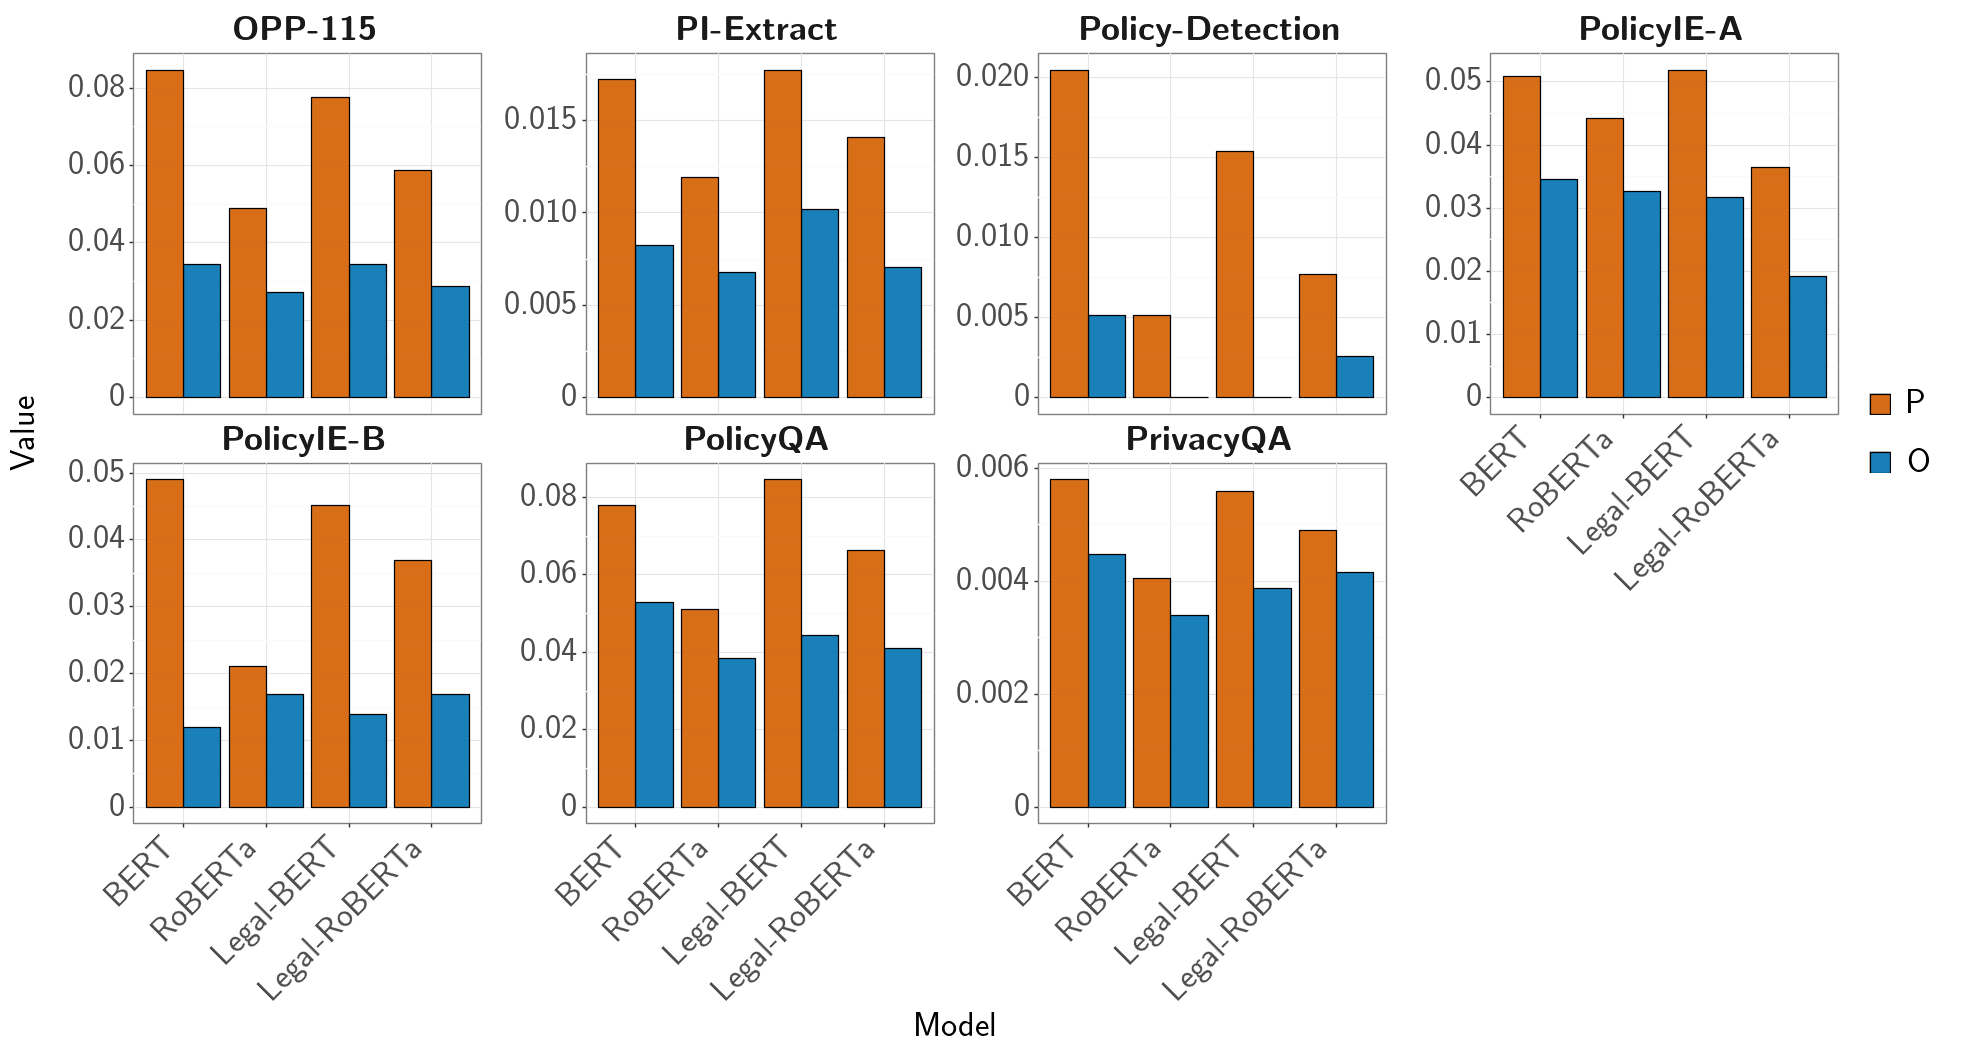

In [8]:
# plot ggplot object
(
    ggplot(df, aes(x="other_model", y="value", fill="variable"))
    + geom_col(stat="identity", position="dodge", color="black", alpha=0.9)
    + facet_wrap("task", nrow=2, scales="free_y")
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, ha="right"),
        axis_title_y=element_text(margin={"r": 20}),
        figure_size=(22, 10),
        text=element_text(size=25),
        legend_text=element_text(margin={"l": 12}),
        legend_title=element_blank(),
        legend_entry_spacing=20,
        strip_background=element_blank(),
        subplots_adjust={"wspace": 0.3},
    )
    + scale_fill_manual(values=["#d55e00", "#0072b2"])
    + labs(x="Model", y="Value")
).draw();

Now we analyze 10 interesting category P and O examples from PrivacyQA.

In [9]:
# convert subset of examples into dataframe
examples_df = pd.DataFrame(examples["bert_base_uncased"]["privacy_qa"])

In [11]:
# sample from category P
examples_df.loc[examples_df["category"] == "P"].sample(10, random_state=42)[
    ["id", "question", "text", "gold_label"]
].to_dict(orient="records")

[{'id': 35515,
  'question': 'does it collect location',
  'text': 'Games may use location-based tracking, which relies upon a mobile devices GPS coordinates.',
  'gold_label': 'Relevant'},
 {'id': 9227,
  'question': 'will the app use my data for marketing purposes?',
  'text': 'We will never share with or sell the information gained through the use of Apple HealthKit, such as age, weight and heart rate data, to advertisers or other agencies without your authorization.',
  'gold_label': 'Relevant'},
 {'id': 45935,
  'question': 'will my test results be shared with any third party entities?',
  'text': '23andMe may share summary statistics, which do not identify any particular individual or contain individual-level information, with our qualified research collaborators.',
  'gold_label': 'Relevant'},
 {'id': 50467,
  'question': 'can i delete my personally identifying information?',
  'text': '(Account Deletion), we allow our customers to delete theiraccounts at any time.',
  'gold_lab

In [12]:
# sample from category O
examples_df.loc[examples_df["category"] == "O"].sample(10, random_state=42)[
    ["id", "question", "text", "gold_label"]
].to_dict(orient="records")

[{'id': 8749,
  'question': 'will my fitness coach share my information with others?',
  'text': 'Develop new services.',
  'gold_label': 'Irrelevant'},
 {'id': 24909,
  'question': 'what information of mine does it access',
  'text': '       the information we collect, how we collect such information and the purposes of our collection;',
  'gold_label': 'Irrelevant'},
 {'id': 45335,
  'question': 'will the information be shared with a 3rd party',
  'text': '"Targeted advertising" service providers We permit third party advertising networks and providers to collect Web-Behavior Information regarding the use of our Services to help us to deliver targeted online advertisements ("ads") to you.',
  'gold_label': 'Relevant'},
 {'id': 31917,
  'question': 'any malware (virus) function worked in this app?',
  'text': 'We encrypt the transmission of all information using secure socket layer technology (SSL).',
  'gold_label': 'Relevant'},
 {'id': 57239,
  'question': 'do you sell any of our da

In [14]:
# provide relative counts of labels in categories
(
    examples_df.groupby("category")["gold_label"].value_counts(
        normalize=True, sort=False
    )[["B", "P", "O", "N"]]
    * 100
).round(0)

category  gold_label
B         Irrelevant    100.0
          Relevant        0.0
P         Irrelevant     29.0
          Relevant       71.0
O         Irrelevant     61.0
          Relevant       39.0
N         Irrelevant      1.0
          Relevant       99.0
Name: gold_label, dtype: float64